# Generations, outgrowth and recruitment limit video

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
intervals = (
    ('days', 86400),    
    ('hours', 3600),    
    ('minutes', 60),
    ('seconds', 1),
    )

def display_time(seconds, granularity=2):
    result = []

    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{} {}".format(value, name))
    return ', '.join(result[:granularity])

In [3]:
def plot_create(t):
    ax1.set_xlabel('Time (days)')
    ax1.set_xlabel('AP position' + ' (' + r'$\mu$'+'m)')
    ax2.set_xlabel('Time (days)')
    ax3.set_xlabel('Time (days)')
    ax1.set_ylabel('Seed number')
    ax2.set_ylabel('Recruitment limit' + ' (' + r'$\mu$'+'m)')
    ax3.set_ylabel('Outgrowth' + ' (' + r'$\mu$'+'m)')
    ax1.set_xlim(-2000,2500)
    ax1.set_ylim(-1,20)    
    ax2.set_xlim(-0.2,8.2)  
    ax2.set_ylim(-2100,0) 
    ax3.set_xlim(-0.2,8.2)
    ax3.set_ylim(-50,2500)      
    ax1.set_yticks([ 0,  4, 9, 14, 19])
    ax1.set_yticklabels([ 1,  5, 10, 15, 20])
    plt.title('time = ' + str(display_time(t*60*60)))
    ax1.yaxis.label.set_size(6)
    ax1.xaxis.label.set_size(6)
    ax2.yaxis.label.set_size(6)
    ax2.xaxis.label.set_size(6)
    ax3.yaxis.label.set_size(6)
    ax3.xaxis.label.set_size(6) 
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    plt.tight_layout()
    filename = "./video/" + str(t).zfill(3) +".png"    
    plt.rcParams.update({'font.size': 6})
    ax1.set_aspect(aspect=50)
    plt.savefig(filename, dpi=300)

In [4]:
n0_mean,n0_std = 196,2 # n0 mean and standar deviation
l_mean,l_std = 828,30      # lambda mean and standar deviation
tau_mean,tau_std = 85,12   # tau mean and standar deviation
parameters = 'n0='+str(n0_mean)+'\n'+'l='+str(l_mean)+'\n'+'tau='+str(tau_mean)+'/'

root = "./main/simulations/"
model = 'switchpoint/'
path = root+model+parameters

files = os.listdir(path)
all_seeds = []
for seed in files:    
    opened_file = open(path+seed)
    data = pd.read_csv(opened_file, delimiter=',')
    outgrowth = data['0']
    all_seeds.append(outgrowth)
all_seeds = pd.concat(all_seeds, ignore_index=True, axis=1)
switchpoint_mean = np.asarray(all_seeds.mean(axis=1))
switchpoint_std = np.asarray(all_seeds.std(axis=1))
switchpoint_time = outgrowth.index/24

root = "./main/simulations/"
model = 'outgrowth3/'
path = root+model+parameters

files = os.listdir(path)
best = {}
for seed in files:    
    opened_file = open(path+seed)
    data = pd.read_csv(opened_file, delimiter=',')
    data.set_index(['time', 'id'], inplace=True)
    proportion = (data.xs(0,level='time').groupby('phase').count().loc['G1'].iloc[0]+data.xs(0,level='time').groupby('phase').count().loc['G0'].iloc[0])/len(data.xs(0,level='time')['phase'])
    best[seed] = proportion
files = list(pd.DataFrame.from_dict(best,orient='index').sort_values(0,ascending=False)[:20].index) 

all_seeds = []
for seed in files:    
    opened_file = open(path+seed)
    data = pd.read_csv(opened_file, delimiter=',')
    data.set_index(['time', 'id'], inplace=True)
    outgrowth = data.groupby(level='time')['position'].max()
    all_seeds.append(outgrowth)
all_seeds = pd.concat(all_seeds, ignore_index=True, axis=1)
outgrowth_mean = np.asarray(all_seeds.mean(axis=1))
outgrowth_max = np.asarray(all_seeds.max(axis=1))
outgrowth_mean = outgrowth_mean[np.logical_not(np.isnan(outgrowth_mean))]
outgrowth_std = np.asarray(all_seeds.std(axis=1))
outgrowth_std = outgrowth_std[np.logical_not(np.isnan(outgrowth_std))]
outgrowth_time = outgrowth.index/24

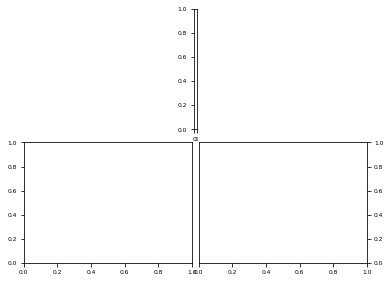

In [34]:
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
times = np.arange(0,193)

positions = []
files = os.listdir(path)
for t in times:
    for i in range(0,20):
        phases_count = {}        
        opened_file = open(path+'/'+str(files[i]))
        data = pd.read_csv(opened_file, delimiter=',')
        data.set_index(['time', 'id'], inplace=True)
        data = data.xs(t,level='time')
        data.loc[data.generation == 0, 'generation'] = 'royalblue'
        data.loc[data.generation == 1, 'generation'] = 'orange'
        data.loc[data.generation == 2, 'generation'] = 'black'
        ax1.scatter(data.position, [i]*len(data.position), s=10, color=data['generation'],edgecolors='white',linewidths=0.1)
    ax1.axvline(x=0, color='black', linestyle='--')
    ax1.axvline(x=outgrowth_max[t], linestyle='-.', color='blue')
    ax1.axvline(x=switchpoint_mean[t], linestyle='-.', color='red')    
    
    # Switchpoint
    ax2.plot(switchpoint_time[0:t], switchpoint_mean[0:t], color='red')
    ax2.fill_between(switchpoint_time[0:t], switchpoint_mean[0:t]-switchpoint_std[0:t], switchpoint_mean[0:t]+switchpoint_std[0:t], facecolor='red', alpha=0.2)
    ax2.fill_between(switchpoint_time[0:t], switchpoint_mean[0:t]-2*switchpoint_std[0:t], switchpoint_mean[0:t]+2*switchpoint_std[0:t], where=(switchpoint_mean[0:t]-2*switchpoint_std[0:t])<(switchpoint_mean[0:t]-switchpoint_std[0:t]), facecolor='red', alpha=0.2)
    ax2.fill_between(switchpoint_time[0:t], switchpoint_mean[0:t]-3*switchpoint_std[0:t], switchpoint_mean[0:t]+3*switchpoint_std[0:t], where=(switchpoint_mean[0:t]-3*switchpoint_std[0:t])<(switchpoint_mean[0:t]-switchpoint_std[0:t]), facecolor='red', alpha=0.15)        
    
    # Outgrowth
    ax3.plot(outgrowth_time[0:t], outgrowth_mean[0:t], color='blue')    
    ax3.fill_between(outgrowth_time[0:t], outgrowth_mean[0:t]-outgrowth_std[0:t], outgrowth_mean[0:t]+outgrowth_std[0:t], facecolor='blue', alpha=0.2)
    ax3.fill_between(outgrowth_time[0:t], outgrowth_mean[0:t]-2*outgrowth_std[0:t], outgrowth_mean[0:t]+2*outgrowth_std[0:t], where=(outgrowth_mean[0:t]-2*outgrowth_std[0:t])<(outgrowth_mean[0:t]-outgrowth_std[0:t]), facecolor='blue', alpha=0.2)
    ax3.fill_between(outgrowth_time[0:t], outgrowth_mean[0:t]-3*outgrowth_std[0:t], outgrowth_mean[0:t]+3*outgrowth_std[0:t], where=(outgrowth_mean[0:t]-3*outgrowth_std[0:t])<(outgrowth_mean[0:t]-outgrowth_std[0:t]), facecolor='blue', alpha=0.15)
    
    plot_create(t)
    ax1.clear()            
    ax2.clear()
    ax3.clear()    